In [1]:
import numpy as np
from numpy import array
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import os
from scipy import ndimage, misc
import math
import glob
import cv2
import sys
from PIL import Image
import pandas as pd

### Load the object detection module, it is mandatory.
### From where you run this code this path will be changed by that relative path. This will run smoothly from /my_codes directory
sys.path.insert(0, "../models/research/object_detection")
from object_detection.utils import ops as utils_ops

from utils import label_map_util
from utils import visualization_utils as vis_util

In [2]:
n_classes = 37
x = tf.placeholder(tf.float32, [None, 224, 224, 3])
Y_ = tf.placeholder(tf.float32, [None, n_classes])
step = tf.placeholder(tf.int32)
keep_prob = tf.placeholder("float")

first_conv_lyr_depth = 64
second_conv_lyr_depth = 128
third_conv_lyr_depth = 256
forth_conv_lyr_depth = 512
fifth_conv_lyr_depth = 512
N = 4096

w1 = tf.Variable(tf.truncated_normal([3, 3, 3, first_conv_lyr_depth], stddev=0.1))
b1 = tf.Variable(tf.ones([first_conv_lyr_depth])/10)
w2 = tf.Variable(tf.truncated_normal([3, 3, first_conv_lyr_depth, second_conv_lyr_depth], stddev=0.1))
b2 = tf.Variable(tf.ones([second_conv_lyr_depth])/10)
w3 = tf.Variable(tf.truncated_normal([3, 3, second_conv_lyr_depth, third_conv_lyr_depth], stddev=0.1))
b3 = tf.Variable(tf.ones([third_conv_lyr_depth])/10)
w4 = tf.Variable(tf.truncated_normal([3, 3, third_conv_lyr_depth, forth_conv_lyr_depth], stddev=0.1))
b4 = tf.Variable(tf.ones([forth_conv_lyr_depth])/10)
w5 = tf.Variable(tf.truncated_normal([3, 3, forth_conv_lyr_depth, fifth_conv_lyr_depth], stddev=0.1))
b5 = tf.Variable(tf.ones([fifth_conv_lyr_depth])/10)
w6 = tf.Variable(tf.truncated_normal([7 * 7 * fifth_conv_lyr_depth, N], stddev=0.1))
b6 = tf.Variable(tf.ones([N])/10)
w7 = tf.Variable(tf.truncated_normal([N, n_classes], stddev=0.1))
b7 = tf.Variable(tf.ones([n_classes])/10)

stride = 1
pooling_stride = 2 
pooling_kernel = [2, 2]
y1 = tf.nn.relu(tf.nn.conv2d(x, w1, strides=[1, stride, stride, 1], padding='SAME') + b1)

pool_1 = tf.layers.max_pooling2d(y1, pooling_kernel, pooling_stride)
y2 = tf.nn.relu(tf.nn.conv2d(pool_1, w2, strides=[1, stride, stride, 1], padding='SAME') + b2)

pool_2 = tf.layers.max_pooling2d(y2, pooling_kernel, pooling_stride)
y3 = tf.nn.relu(tf.nn.conv2d(pool_2, w3, strides=[1, stride, stride, 1], padding='SAME') + b3)

pool_3 = tf.layers.max_pooling2d(y3, pooling_kernel, pooling_stride)
y4 = tf.nn.relu(tf.nn.conv2d(pool_3, w4, strides=[1, stride, stride, 1], padding='SAME') + b4)

pool_4 = tf.layers.max_pooling2d(y4, pooling_kernel, pooling_stride)
y5 = tf.nn.relu(tf.nn.conv2d(pool_4, w5, strides=[1, stride, stride, 1], padding='SAME') + b5)

pool_5 = tf.layers.max_pooling2d(y5, pooling_kernel, pooling_stride)
y6 = tf.layers.dense(pool_5, units=512, activation=tf.nn.relu)

yy = tf.reshape(y6, shape=[-1, 7 * 7 * 512])
fc1 = tf.nn.relu(tf.matmul(yy, w6) + b6)

Ylogits = tf.matmul(fc1, w7) + b7
Y = tf.nn.softmax(Ylogits)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=Ylogits, labels=Y_)
cross_entropy = tf.reduce_mean(cross_entropy)*100

correct_prediction = tf.equal(tf.argmax(Y, 1), tf.argmax(Y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

lr = 0.01 +  tf.train.exponential_decay(0.03, step, 2000, 1/math.e)
train_step = tf.train.AdamOptimizer(lr).minimize(cross_entropy)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [3]:
def getActivations(layer, all_images, sess):
    units = sess.run(layer, feed_dict={x:array(all_images).reshape(all_images.shape), keep_prob:1.0}) 
    #all_images = size(all_images)x224x224x3
    #plotNNFilter(units)
    return units

In [4]:
def train (sess, train_images, train_labels_one_hot, steps_for_each_set):
    for i in range(steps_for_each_set):
        train_data = {x: train_images, Y_: train_labels_one_hot, step: i}
        sess.run(train_step, feed_dict=train_data)
        a, c, l = sess.run([accuracy, cross_entropy, lr], feed_dict=train_data)
        print(str(i) + ": accuracy:" + str(a) + " loss: " + str(c) + " (lr:" + str(l) + ")")

In [5]:
def plotNNFilter(units):
    filters = units.shape[3]
    print(filters)
    plt.figure(1, figsize=(20, 20))
    n_columns = 8
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters):
        #plt.subplot(n_rows, n_columns, i+1)
        #plt.title('Filter ' + str(i))
        plt.imshow(units[0,:,:,i])
        print(array(units[0,:,:,i]).shape)
        plt.savefig("feature_map_output/feature_map_" + str(i) + ".jpg")
    #plt.show()

In [6]:
def get_image_label_indexs (category_index, image_paths):
    y_label_id = []
    y_label_name = []
    for image_path in image_paths:
        actual_class_name = os.path.basename(image_path).rsplit('_', 1)[0]
        for i in category_index.keys():
            if category_index[i]['name'] == actual_class_name:
                y_label_id.append(category_index[i]['id'])
                y_label_name.append(category_index[i]['name'])
    return y_label_id, y_label_name

In [31]:
def get_data_and_label (images_path):
    MODEL_NAME = 'downloaded_models/resnet101_pet_aneeq_additional_model'
    PATH_TO_LABELS = MODEL_NAME + '/pet_label_map.pbtxt'
    PATH_TO_TEST_IMAGES_DIR = images_path
    IMAGE_PATHS = glob.glob(PATH_TO_TEST_IMAGES_DIR+"/*.jpg")

    x_data = np.array([np.array(Image.open(IMAGE_PATHS[i]).resize((224, 224), Image.ANTIALIAS)) 
                       for i in range(len(IMAGE_PATHS))])
    x_data = x_data
    print(x_data.shape)
    

    category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)
    y_label_ids, y_label_names = get_image_label_indexs (category_index, IMAGE_PATHS)
    print(y_label_ids)
    ids = pd.Series(y_label_ids)
    y_label_one_hot = pd.get_dummies(ids)
    print(y_label_one_hot.shape)
    #print(y_label_names)
    
    return x_data, y_label_ids, y_label_one_hot, y_label_names, category_index

In [8]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

In [85]:
x_data, y_label_ids, y_label_one_hot, y_label_names, category_index = get_data_and_label("train_images")
x_data = x_data / 255.0

(8, 224, 224, 3)
[1, 1, 2, 2, 5, 8, 8, 5]
(8, 4)


In [ ]:
steps = 10
train (sess, x_data, y_label_one_hot, steps)

In [86]:
features = getActivations(fc1, x_data, sess)
print(features.shape)

(8, 4096)


In [87]:
feat_cols = [ 'pixel'+str(i) for i in range(features.shape[1]) ]
print(len(feat_cols))

df = pd.DataFrame(features, columns=feat_cols)
df['label'] = y_label_ids
df['label'] = df['label'].apply(lambda i: str(i))
df['label_name'] = y_label_names
df['label_name'] = df['label_name'].apply(lambda i: str(i))
df_prototypes = df.groupby(['label','label_name'], as_index=False).mean()
df_prototypes_label_id = df_prototypes['label']
df_prototypes_label_name = df_prototypes['label_name']
df_prototypes = df.groupby(['label','label_name']).mean()
df = df_prototypes
print(df.shape)
print(df_prototypes.shape)

4096
(4, 4096)
(4, 4096)


In [121]:
import scipy
x_data, y_label_ids, y_label_one_hot, y_label_names, category_index = get_data_and_label('validation_images')
x_data = x_data / 255.0
features = getActivations(fc1, x_data, sess)
feat_cols = [ 'pixel'+str(i) for i in range(features.shape[1]) ]
#print(len(feat_cols))

df_validation = pd.DataFrame(features, columns=feat_cols)
#print(df_validation.shape)
arr = -scipy.spatial.distance.cdist(df_validation.iloc[:,1:], df_prototypes.iloc[:,1:], metric='euclidean')
arr = arr / 1000
arr_x = np.exp(arr)
total_dist = np.log(np.sum(arr_x, axis=1))
#print(arr)
for i in range(len(arr)):
    #print(total_dist[i])
    #print(arr[i])
    #print(arr[i]+total_dist[i])
    arr[i] = arr[i] + total_dist[i]
arr / (2*2)
    

(8, 224, 224, 3)
[1, 1, 2, 2, 5, 5, 8, 8]
(8, 4)


array([[-0.40960063, -0.47235066, -0.32991984, -0.47858431],
       [-0.99265223, -0.59771421, -0.79335704, -0.69195624],
       [-0.64514226, -0.49703039, -0.5362196 , -0.50854536],
       [-0.77979423, -0.56067476, -0.61530927, -0.6557519 ],
       [-0.58147416, -0.47151525, -0.43553487, -0.50433255],
       [-0.5114389 , -0.58322071, -0.43264885, -0.60063868],
       [-1.30166791, -0.970293  , -1.08028841, -0.95903052],
       [-0.64541873, -0.54382937, -0.53060189, -0.51205402]])

In [26]:
rndperm = np.random.permutation(df.shape[0])

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt


# Plot the graph
plt.gray()
fig = plt.figure( figsize=(16,7) )
for i in range(0,4):
    ax = fig.add_subplot(3,10,i+1, title='Digit: ' + str(df.loc[rndperm[i],'label']) )
    ax.matshow(df.loc[rndperm[i],feat_cols].values.reshape((64, 64)).astype(float))

plt.show()

In [28]:
import time

from sklearn.manifold import TSNE

n_sne = 7000

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df.loc[rndperm[:n_sne],feat_cols].values)


print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 3 nearest neighbors...
[t-SNE] Indexed 4 samples in 0.000s...
[t-SNE] Computed neighbors for 4 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 4 / 4
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 39.260231
[t-SNE] KL divergence after 300 iterations: 0.056896
t-SNE done! Time elapsed: 0.06365585327148438 seconds


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

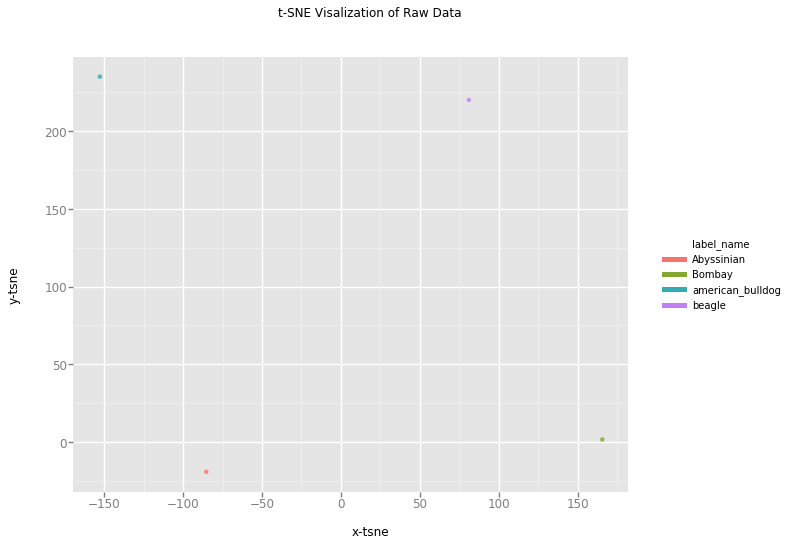

<ggplot: (-9223363279225733197)>

In [29]:
from ggplot import *

df_tsne = df.loc[rndperm[:n_sne],:].copy()
df_tsne['x-tsne'] = tsne_results[:,0]
df_tsne['y-tsne'] = tsne_results[:,1]

chart = ggplot( df_tsne, aes(x='x-tsne', y='y-tsne', color='label_name' )) \
        + geom_point(size=20,alpha=0.8) \
        + ggtitle("t-SNE Visalization of Raw Data") 
chart